This notebook demonstrates Kausal framework on ENSO dynamics.

References: 

- https://www.aoml.noaa.gov/phod/docs/2004_Wang_Picaut.pdf
- https://journals.ametsoc.org/view/journals/atsc/54/7/1520-0469_1997_054_0811_aeorpf_2.0.co_2.xml

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import numpy as np
import torch
import torchdiffeq

import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm

from kausal.generator import enso
from kausal.koopman import Kausal
from kausal import stats


# 1. Generate dynamics 


$$
\frac{\partial T}{\partial t} = -r T - \mu \alpha b_0 h
$$

$$
\frac{\partial h}{\partial t} = \gamma T + (\gamma \mu b_0 - c) h
$$


### 1a. Specify parameters, ICs, timestepping

In [3]:
# Time span
t0, t1 = 0.0, 100.0
dt = 0.01
steps = int((t1 - t0) / dt)
n_train = int(0.8 * steps)

# Parameters
r, alpha, b0, c, gamma = 0.25, 0.125, 2.5, 1.0, 0.75
mu = 2/3 # Coupling term

# Initial condition
initial_state = torch.tensor([1.0, 1.0])


### 1b. Integrate forward

In [4]:
# Integration
solver = torchdiffeq.odeint

def solve_dynamics(t0, t1, dt, initial_state, params):
    """Solve dynamics"""
    t = torch.linspace(t0, t1, int((t1 - t0) / dt))
    dynamics = lambda t, state: enso(t, state, params)
    
    solution = solver(
        dynamics,
        initial_state,
        t,
        method = 'dopri5',
        options = {'max_num_steps': 100000}
    )
    return t, solution

params = (r, alpha, b0, c, gamma, mu)

# Solve the system
t, solution = solve_dynamics(t0, t1, dt, initial_state, params)

# Extract results
omega = solution.T


### 1c. Dynamics analysis

We can analyze the bifurcation phase diagram by varying $\mu$

/local/ipykernel_1397542/4294965931.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  eigenvalues = torch.tensor(eigenvalues)


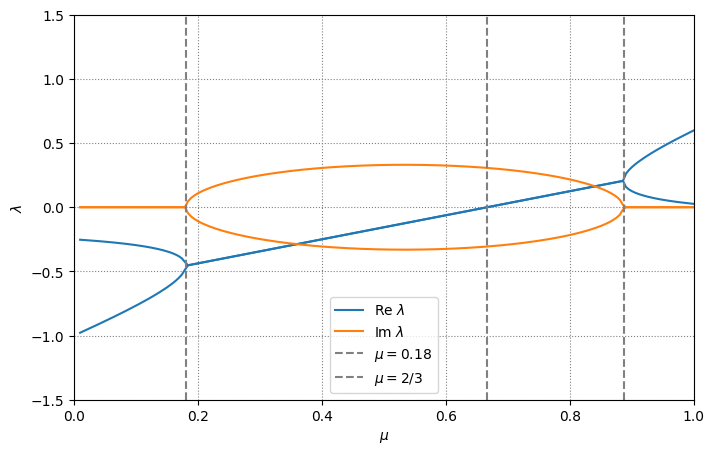

In [5]:
def compute_jacobian(T, h, args):
    """
    Compute the Jacobian matrix for the ENSO system.
    
    Parameters:
        T, h: State variables.
        args: Model parameters.
    
    Returns:
        Jacobian matrix (2x2 numpy array).
    """
    r, alpha, b0, c, gamma, mu = args

    # Partial derivatives
    dT_dT = -r
    dT_dh = -mu * alpha * b0
    dh_dT = gamma
    dh_dh = gamma * mu * b0 - c

    # Jacobian matrix
    return torch.tensor([[dT_dT, dT_dh], [dh_dT, dh_dh]])


# Define parameters
r, alpha, b0, c, gamma = 0.25, 0.125, 2.5, 1.0, 0.75
muvec = np.linspace(0.01, 1.0, 200)  # Range of mu values

# Compute eigenvalues for each value of mu
eigenvalues = []
for mu in muvec:
    args = (r, alpha, b0, c, gamma, mu)
    jacobian = compute_jacobian(0, 0, args)  # Jacobian evaluated at T=0, h=0 (fixed point)
    eigenvalues.append(torch.linalg.eigvals(jacobian).numpy())
eigenvalues = torch.tensor(eigenvalues)

# Plotting eigenvalues
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\lambda$')
ax.set_xlim(0, 1)
ax.set_ylim(-1.5, 1.5)
ax.grid(ls='dotted', color='grey')

# Real and imaginary parts
ax.plot(muvec, np.real(eigenvalues[:, 0]), color='C0', label=r'Re $\lambda$')
ax.plot(muvec, np.real(eigenvalues[:, 1]), color='C0')
ax.plot(muvec, np.imag(eigenvalues[:, 0]), color='C1', label=r'Im $\lambda$')
ax.plot(muvec, np.imag(eigenvalues[:, 1]), color='C1')

# Mark critical values of mu
ax.axvline(x=0.18, color='grey', ls='dashed', label=r'$\mu = 0.18$')
ax.axvline(x=0.887, color='grey', ls='dashed')
ax.axvline(x=2/3, color='grey', ls='dashed', label=r'$\mu = 2/3$')

ax.legend()
plt.show()

We can plot sample trajectories given different $\mu$: e.g., dissipative, critical, unstable oscillations...

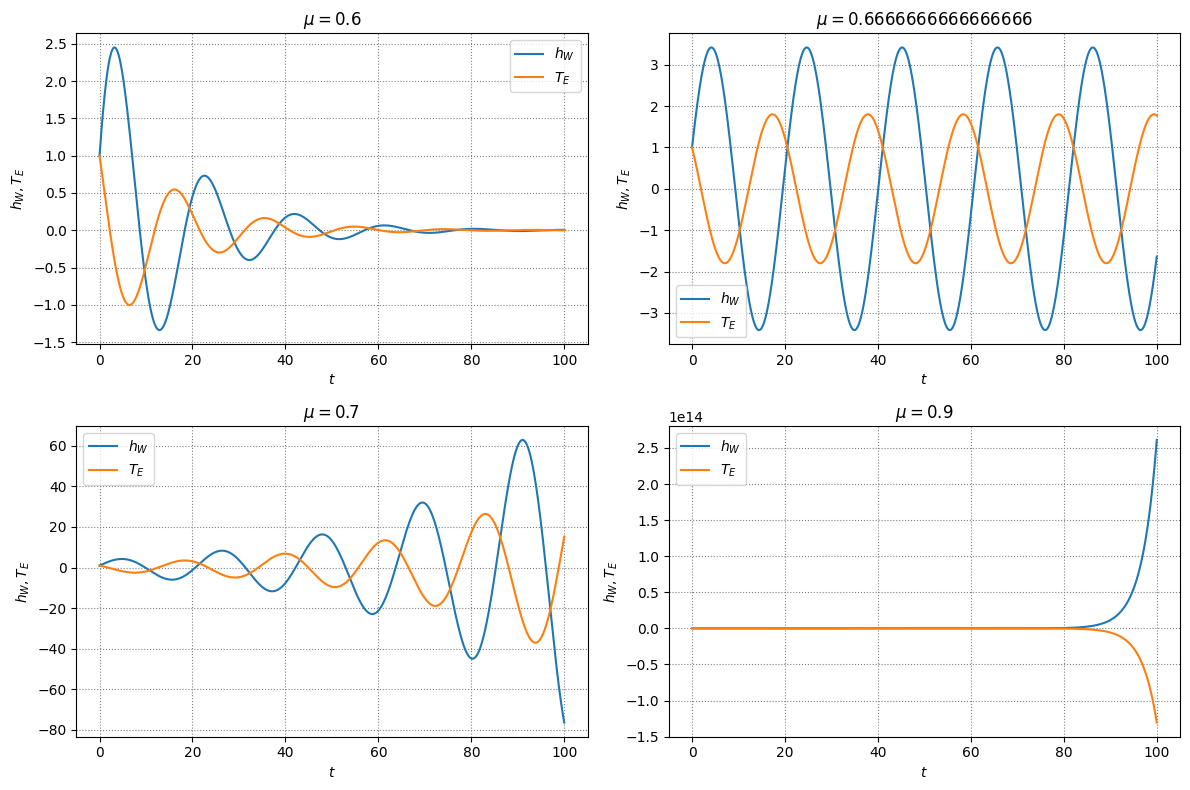

In [6]:
# Plotting for different mu values
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
axes = [ax1, ax2, ax3, ax4]
mu_values = [0.6, 2/3, 0.7, 0.9]

for mu, ax in zip(mu_values, axes):
    params = (r, alpha, b0, c, gamma, mu)
    t, solution = solve_dynamics(t0, t1, dt, initial_state, params)

    omega = solution.T
    
    # Plot h_W and T_E
    ax.plot(t, omega[1], label=r'$h_W$', color='C0')
    ax.plot(t, omega[0], label=r'$T_E$', color='C1')
    ax.set_title(f"$\mu = {mu}$")
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$h_W, T_E$')
    ax.grid(ls='dotted', color='grey')
    ax.legend()

plt.tight_layout()
plt.show()

We can also generate the vector field to visualize stationary points...

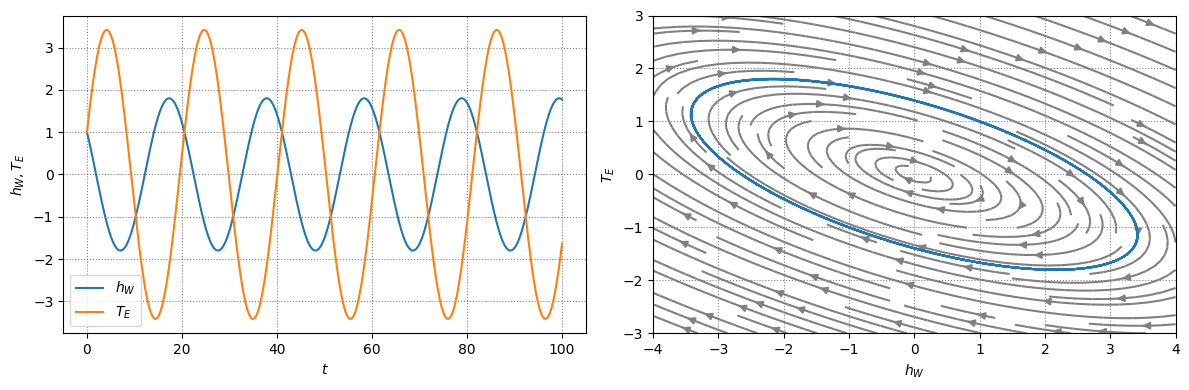

In [7]:
# Solve the system (oscillatory regime)
mu = 2/3
params = (r, alpha, b0, c, gamma, mu)
t, solution = solve_dynamics(t0, t1, dt, initial_state, params)
omega = solution.T

# Generate vector field for phase portrait
hvec = np.linspace(-4.0, 4.0, 50)
Tvec = np.linspace(-3.0, 3.0, 50)
H, T = np.meshgrid(hvec, Tvec)

# Compute vector field for the grid point
F = np.array([[enso(0, torch.tensor([T_, h_]), params).numpy() for h_ in hvec] for T_ in Tvec])
dT_field, dh_field = F[:, :, 0], F[:, :, 1]

# Normalize the vector field for uniform arrow sizes in the streamplot
magnitude = np.sqrt(dh_field**2 + dT_field**2)
dh_field /= magnitude
dT_field /= magnitude

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Subplot 1: Time series
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$h_W, T_E$')
ax1.grid(ls='dotted', color='grey')

initial_states = [torch.tensor([1.0, 1.0])]
for initial_state in initial_states:
    t, solution = solve_dynamics(t0, t1, dt, initial_state, params)
    omega = solution.T.numpy()
    ax1.plot(t.numpy(), omega[0], label=r'$h_W$' if initial_state[0] == 1.0 else None, color='C0', ls='-' if initial_state[0] == 1.0 else 'dashed')
    ax1.plot(t.numpy(), omega[1], label=r'$T_E$' if initial_state[0] == 1.0 else None, color='C1', ls='-' if initial_state[0] == 1.0 else 'dashed')

ax1.legend()

# Subplot 2: Phase portrait with streamlines
ax2.set_xlabel(r'$h_W$')
ax2.set_ylabel(r'$T_E$')
ax2.grid(ls='dotted', color='grey')

# Streamplot with normalized field for uniformity
ax2.streamplot(hvec, Tvec, dh_field, dT_field, color='grey', density=1.2)

# Add trajectories to the phase portrait
for initial_state in initial_states:
    t, solution = solve_dynamics(t0, t1, dt, initial_state, params)
    omega = solution.T.numpy()
    ax2.plot(omega[1], omega[0], color='C0' if initial_state[0] == 1.0 else 'C1', ls='-' if initial_state[0] == 1.0 else 'dashed')

plt.tight_layout()
plt.show()


# 2. Causal Koopman

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.38it/s]


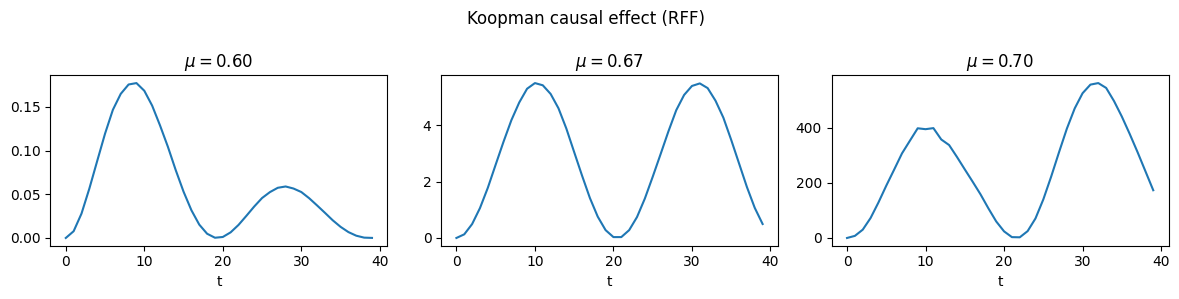

In [8]:
time_shifts = torch.arange(1, 2000, 50)
mus = [0.6, 2/3, 0.7]
initial_state = torch.tensor([1.0, 1.0])

f, ax = plt.subplots(1, len(mus), figsize=(12,3))

# Causal time shift analysis
for mu_i, mu in enumerate(mus):
    
    # Solve dynamics
    params = (r, alpha, b0, c, gamma, mu)
    t, solution = solve_dynamics(t0, t1, dt, initial_state, params)
    omega = solution.T

    # Causal inference
    causal_koopman = Kausal(
        cause = omega[0:1],
        effect = omega[1:2],
    )

    causal_effect = causal_koopman.evaluate_multistep(time_shifts = time_shifts)

    f.suptitle(f"Koopman causal effect (MLP)\n($\mu = {mu:.2f}$)")
    ax[mu_i].plot(causal_effect)
    ax[mu_i].set_title(f"$\mu = {mu:.2f}$")
    ax[mu_i].set_xlabel('t')

f.suptitle(f"Koopman causal effect (RFF)")
plt.tight_layout()
plt.show();


# 3. Deep Causal Koopman

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 71.32it/s]


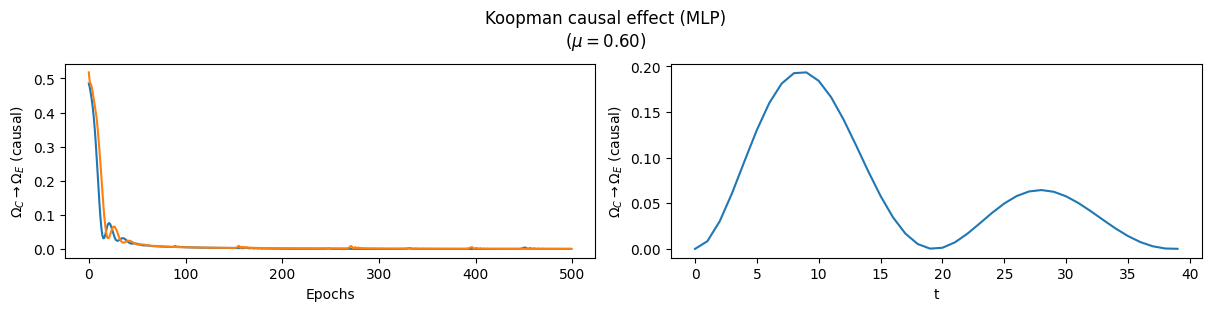

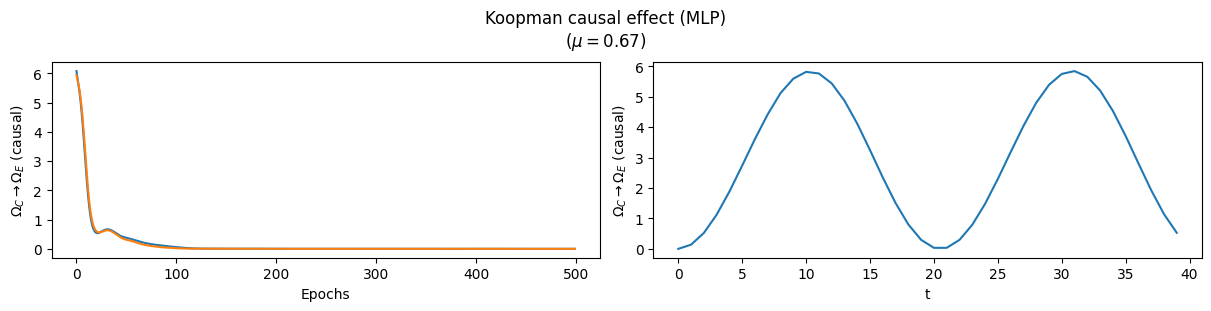

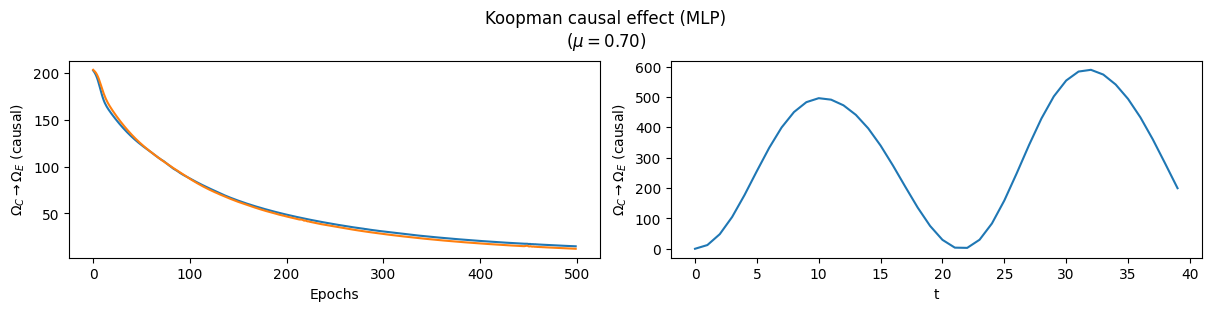

In [10]:
# Causal shifts
from kausal.observables import MLPFeatures

time_shifts = torch.arange(1, 2000, 50)
mus = [0.6, 2/3, 0.7]
initial_state = torch.tensor([1.0, 1.0])

# Hyperparameters
hidden_channels = [16, 32]
lr = 1e-2
epochs = 500

# Causal time shift analysis for each mu
for mu_i, mu in enumerate(mus):

    f, ax = plt.subplots(1, 2, figsize=(12,3), constrained_layout=True)
    
    # Solve dynamics
    params = (r, alpha, b0, c, gamma, mu)
    t, solution = solve_dynamics(t0, t1, dt, initial_state, params)
    omega = solution.T

    # Causal inference
    causal_koopman = Kausal(
        marginal_observable = MLPFeatures(in_channels=1, hidden_channels=hidden_channels, out_channels=1),
        joint_observable = MLPFeatures(in_channels=2, hidden_channels=hidden_channels, out_channels=1),
        cause = omega[0:1],
        effect = omega[1:2],
    )

    # Fit observable functions
    marginal_loss_ce, joint_loss_ce = causal_koopman.fit(
        n_train = n_train, 
        epochs = epochs, 
        lr = lr, 
        batch_size = n_train
    )

    # Perform multistep causal analysis
    causal_effect = causal_koopman.evaluate_multistep(time_shifts = time_shifts)
    
    # Plot
    ax[0].plot(marginal_loss_ce, label='marginal model')
    ax[0].plot(joint_loss_ce, label='joint model')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')

    ax[1].plot(causal_effect)
    ax[1].set_ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')
    ax[1].set_xlabel('t')

    f.suptitle(f"Koopman causal effect (MLP)\n($\mu = {mu:.2f}$)")

plt.show();
